In [78]:

import numpy as np
import pandas as pd
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.callback import EarlyStopping

import warnings
warnings.filterwarnings('ignore')



In [79]:
df = pd.read_csv('Data/titanic.csv')
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df = pd.get_dummies(df)


In [80]:
target = 'Survived'
y = df[target]

X = df.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
model = XGBClassifier(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)


[0]	validation_0-logloss:0.61223	validation_1-logloss:0.63728


[100]	validation_0-logloss:0.21399	validation_1-logloss:0.43380
[200]	validation_0-logloss:0.15503	validation_1-logloss:0.46494
[300]	validation_0-logloss:0.12462	validation_1-logloss:0.49907
[400]	validation_0-logloss:0.10727	validation_1-logloss:0.53620
[500]	validation_0-logloss:0.09491	validation_1-logloss:0.54877
[600]	validation_0-logloss:0.08772	validation_1-logloss:0.56103
[700]	validation_0-logloss:0.08238	validation_1-logloss:0.56915
[800]	validation_0-logloss:0.07763	validation_1-logloss:0.58425
[900]	validation_0-logloss:0.07402	validation_1-logloss:0.59773
[1000]	validation_0-logloss:0.07082	validation_1-logloss:0.60711
[1100]	validation_0-logloss:0.06890	validation_1-logloss:0.63391
[1200]	validation_0-logloss:0.06620	validation_1-logloss:0.62561
[1300]	validation_0-logloss:0.06516	validation_1-logloss:0.64662
[1400]	validation_0-logloss:0.06331	validation_1-logloss:0.64723
[1500]	validation_0-logloss:0.06218	validation_1-logloss:0.64979
[1600]	validation_0-logloss:0.0613

XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None, ...)

In [82]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.8585585585585584

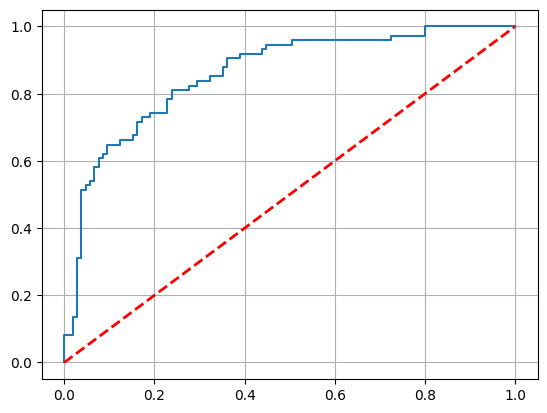

In [83]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

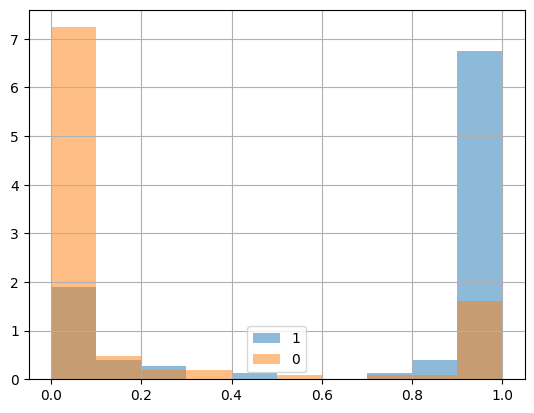

In [84]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

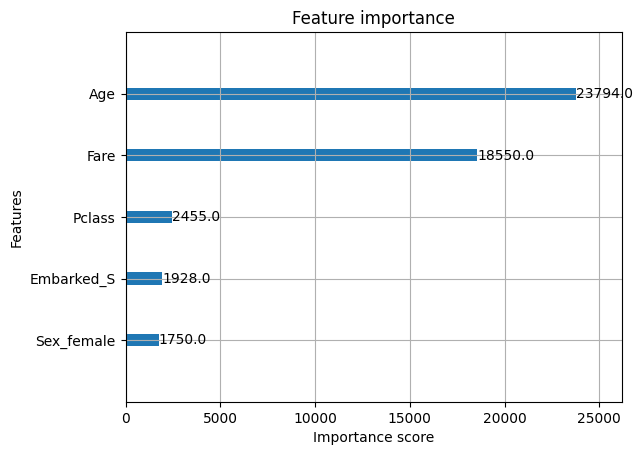

In [85]:
plot_importance(model, max_num_features=5, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

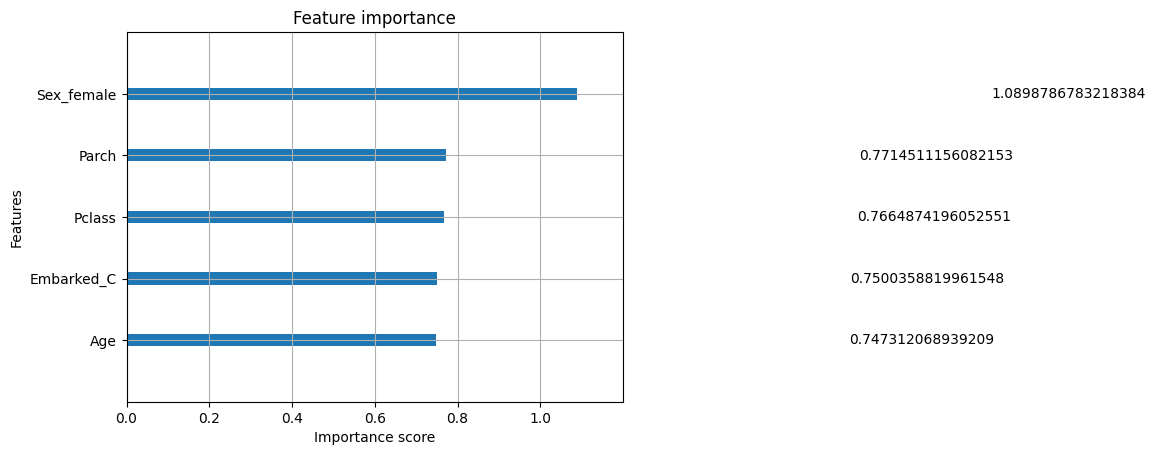

In [86]:
plot_importance(model, max_num_features=5, importance_type='gain')

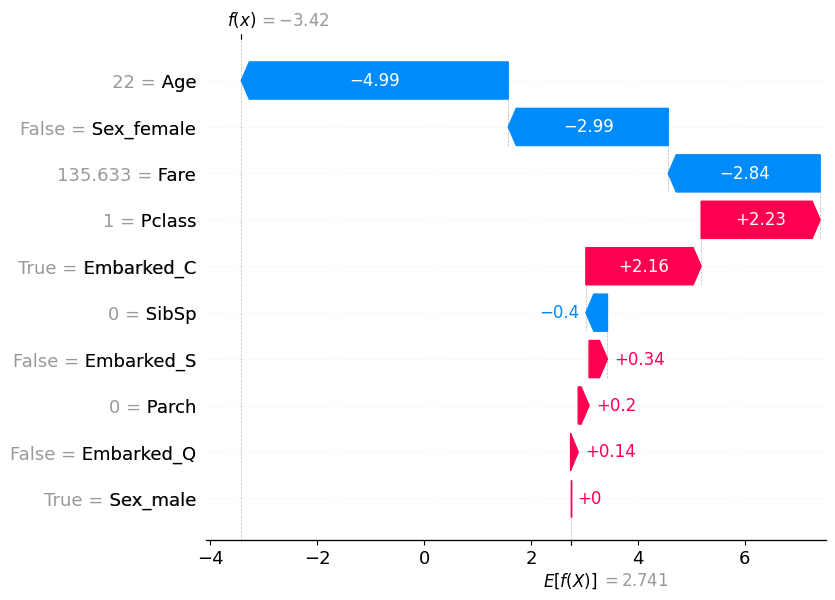

In [87]:
X_shap = X_train.copy()
X_shap = X_train.sample(100, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_shap.iloc[0], 
    feature_names=X_shap.keys()
))


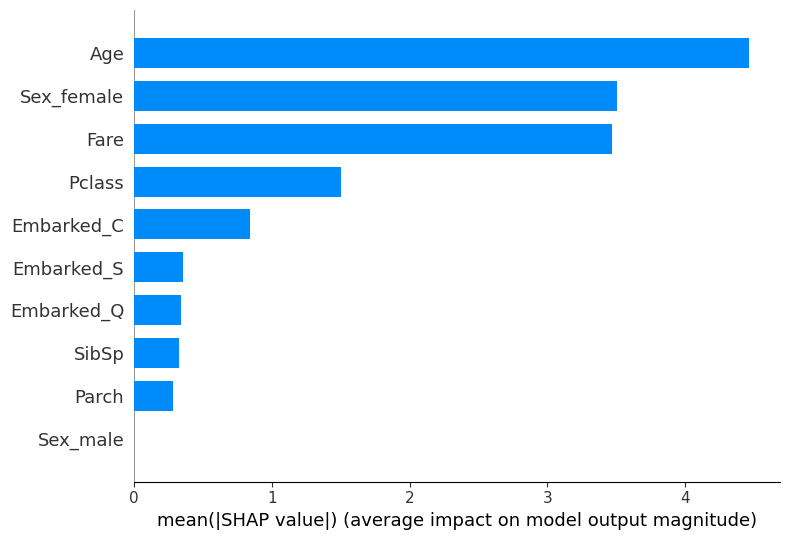

In [88]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

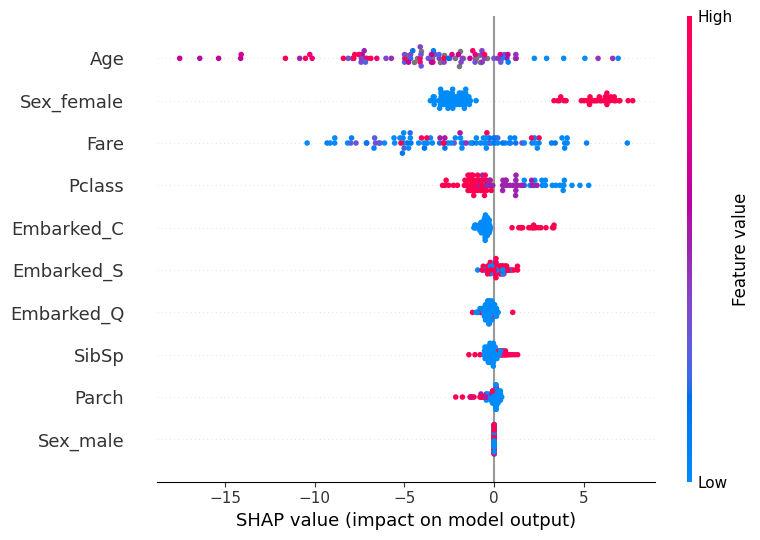

In [89]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")

Text(0, 0.5, 'Inertia')

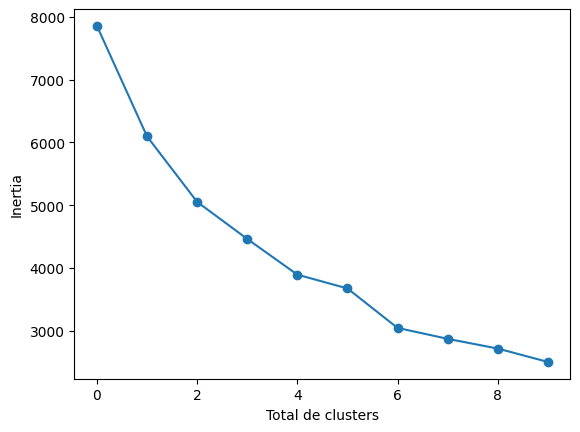

In [90]:
df = df.copy().dropna()

inertias = []

K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(df)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(inertias, marker='o')
plt.xlabel('Total de clusters')
plt.ylabel('Inertia')

In [97]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])
pipeline.fit(df)
df['cluster'] = pipeline.predict(df)

